<a href="https://colab.research.google.com/github/Data-Science-and-Data-Analytics-Courses/UCSanDiegoX---Machine-Learning-Fundamentals-03-Jan-2019-audit/blob/master/Week%2004%20Linear%20Regression%20and%20Probability%20Estimation/diabetes-regression/diabetes-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting the progression of diabetes using least-squares regression

The **diabetes** data set described in lecture can be obtained as a single file, `diabetes-data.csv`, from the course website. We obtained it at https://web.stanford.edu/~hastie/Papers/LARS/diabetes.data. For some background information on the data, see this seminal paper:

Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani (2004) "Least Angle Regression," Annals of Statistics (with discussion), 407-499.

Before you start on this notebook, install `diabetes-data.csv` in the same directory. We will walk through some of the examples from lecture as well as giving you some problems to solve.


# Clone remote

In [1]:
import os, sys

URL = "http://github.com/Data-Science-and-Data-Analytics-Courses/UCSanDiegoX---Machine-Learning-Fundamentals-03-Jan-2019-audit"
NBDIR = "Week 04 Linear Regression and Probability Estimation/diabetes-regression"
!git clone "$URL"
%cd "UCSanDiegoX---Machine-Learning-Fundamentals-03-Jan-2019-audit"
%run .Importable.ipynb
sys.path.append(os.getcwd())
%cd "$NBDIR"

Cloning into 'UCSanDiegoX---Machine-Learning-Fundamentals-03-Jan-2019-audit'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 721 (delta 39), reused 10 (delta 4), pack-reused 645
Receiving objects: 100% (721/721), 3.19 MiB | 2.91 MiB/s, done.
Resolving deltas: 100% (359/359), done.
/content/UCSanDiegoX---Machine-Learning-Fundamentals-03-Jan-2019-audit


/content/UCSanDiegoX---Machine-Learning-Fundamentals-03-Jan-2019-audit/Week 04 Linear Regression and Probability Estimation/diabetes-regression


## 1. Set up notebook and load data set

In [0]:
# Standard includes
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# Routines for linear regression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
# Set label size for plots
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

This next snippet of code loads in the diabetes data. There are 442 data points, each with 10 predictor variables (which we'll denote `x`) and one response variable (which we'll denote `y`).

Make sure the file `'diabetes-data.csv'` is in the same directory as this notebook.

In [0]:
data = np.genfromtxt('diabetes-data.csv', delimiter=',')
features = ['age', 'sex', 'body mass index', 'blood pressure', 
            'serum1', 'serum2', 'serum3', 'serum4', 'serum5', 'serum6']
x = data[:,0:10] # predictors
y = data[:,10] # response variable

## 2. Predict `y` without using `x`

If we want to predict `y` without knowledge of `x`, what value would be predict? The <font color="magenta">mean</font> value of `y`.

In this case, the mean squared error (MSE) associated with the prediction is simply the variance of `y`.

In [4]:
print("Prediction: ", np.mean(y))
print("Mean squared error: ", np.var(y))

Prediction:  152.13348416289594
Mean squared error:  5929.884896910383


## 3. Predict `y` using a single feature of `x`

To fit a linear regression model, we could directly use the formula we saw in lecture. To make things even easier, this is already implemented in `sklearn.linear_model.LinearRegression()`.

Here we define a function, **one_feature_regression**, that takes `x` and `y`, along with the index `f` of a single feature and fits a linear regressor to `(x[f],y)`. It then plots the data along with the resulting line.

In [0]:
def one_feature_regression(x,y,f):
    if (f < 0) or (f > 9):
        print("Feature index is out of bounds")
        return
    regr = linear_model.LinearRegression()
    x1 = x[:,[f]]
    regr.fit(x1, y)
    # Make predictions using the model
    y_pred = regr.predict(x1)
    # Plot data points as well as predictions
    plt.plot(x1, y, 'bo')
    plt.plot(x1, y_pred, 'r-', linewidth=3)
    plt.xlabel(features[f], fontsize=14)
    plt.ylabel('Progression of disease', fontsize=14)
    plt.show()
    print("Mean squared error: ", mean_squared_error(y, y_pred))
    return regr

Let's try this with feature #2 (body mass index).

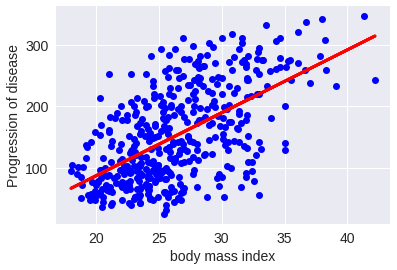

Mean squared error:  3890.456585461273
w =  [10.23312787]
b =  -117.77336656656527


In [6]:
regr = one_feature_regression(x,y,2)
print("w = ", regr.coef_)
print("b = ", regr.intercept_)

<font color="magenta">For you to try:</font> Feature #2 ('body mass index') is the single feature that yields the lowest mean squared error. Which feature is the second best? 

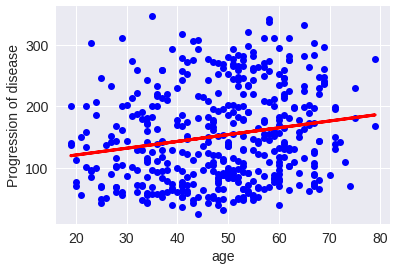

Mean squared error:  5720.547017205647


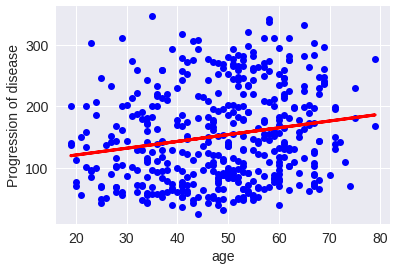

Mean squared error:  5720.547017205647


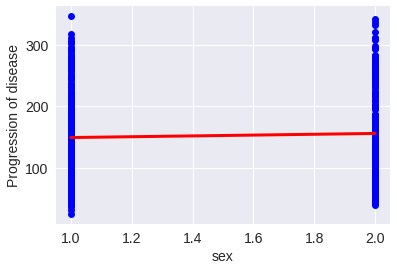

Mean squared error:  5918.888899586022


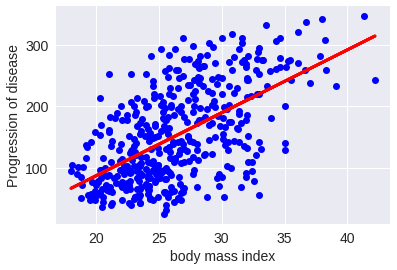

Mean squared error:  3890.456585461273


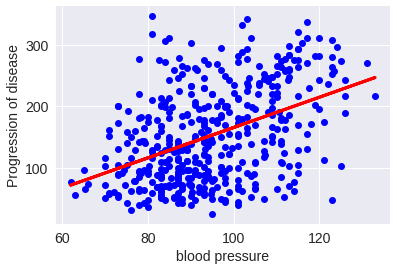

Mean squared error:  4774.113902368687


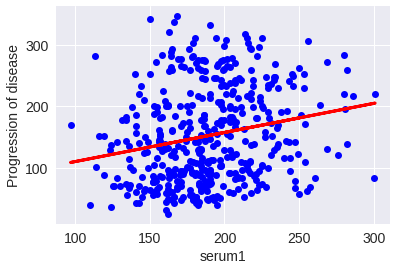

Mean squared error:  5663.315623739354


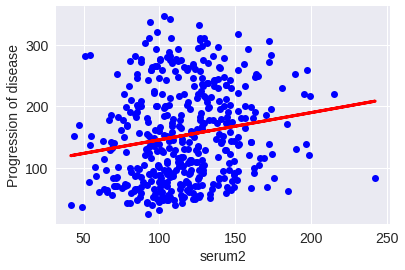

Mean squared error:  5750.241102677781


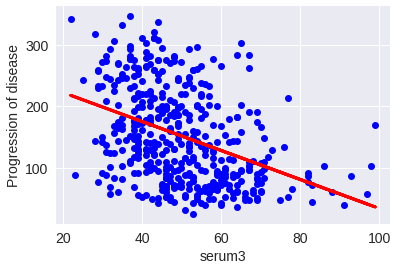

Mean squared error:  5005.661620710652


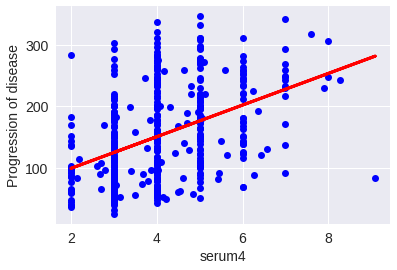

Mean squared error:  4831.13838643409


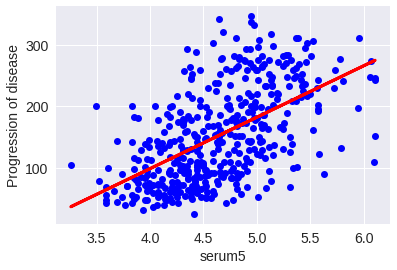

Mean squared error:  4030.998722591287


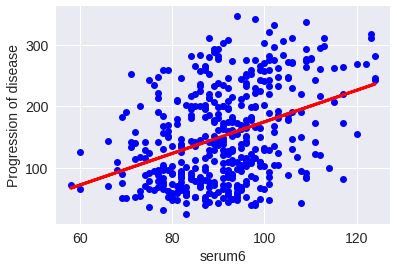

Mean squared error:  5062.380594520543
Second best feature: serum5


In [7]:
### You can use this space to figure out the second-best feature
vone_feature_regression = np.vectorize(one_feature_regression, excluded=["x", "y"])
regressors = vone_feature_regression(f=range(len(features)), x=x, y=y)
mse = np.zeros(len(regressors))
for f, regr in enumerate(regressors):
  y_pred = regr.predict(x[:, [f]])
  mse[f] = mean_squared_error(y, y_pred)
print("Second best feature: {}".format(features[mse.argsort()[1]]))

## 3. Predict `y` using a specified subset of features from `x`

The function **feature_subset_regression** is just like **one_feature_regression**, but this time uses a list of features `flist`.

In [0]:
def feature_subset_regression(x,y,flist):
    if len(flist) < 1:
        print("Need at least one feature")
        return
    for f in flist:
        if (f < 0) or (f > 9):
            print("Feature index is out of bounds")
            return
    regr = linear_model.LinearRegression()
    regr.fit(x[:,flist], y)
    return regr

Try using just features #2 (body mass index) and #8 (serum5).

In [9]:
flist = [2,8]
regr = feature_subset_regression(x,y,[2,8])
print("w = ", regr.coef_)
print("b = ", regr.intercept_)
print("Mean squared error: ", mean_squared_error(y, regr.predict(x[:,flist])))

w =  [ 7.27600054 56.05638703]
b =  -299.95751508023613
Mean squared error:  3205.190076824853


Finally, use all 10 features.

In [10]:
regr = feature_subset_regression(x,y,range(0,10))
print("w = ", regr.coef_)
print("b = ", regr.intercept_)
print("Mean squared error: ", mean_squared_error(y, regr.predict(x)))

w =  [-3.63612242e-02 -2.28596481e+01  5.60296209e+00  1.11680799e+00
 -1.08999633e+00  7.46450456e-01  3.72004715e-01  6.53383194e+00
  6.84831250e+01  2.80116989e-01]
b =  -334.5671385187876
Mean squared error:  2859.6963475867506


## 4. Splitting the data into a training and test set

In the experiments above, every model was fit to the *entire* data set and its mean squared error was evaluated on this same data set. This methodology would not, in general, yield accurate estimates of future error. In this specific case, however, the discrepancy might not be too bad because the data set is quite large relative to the number of features.

To investigate this further, we define a procedure **split_data** that partitions the data set into separate training and test sets. It is invoked as follows:

* `trainx, trainy, testx, testy = split_data(n_train)`

Here:
* `n_train` is the desired number of training points
* `trainx` and `trainy` are the training points and response values
* `testx` and `testy` are the test points and response values

The split is done randomly, but the random seed is fixed, and thus the same split is produced if the procedure is called repeatedly with the same `n_train` parameter.

In [0]:
def split_data(n_train):
    if (n_train < 0) or (n_train > 442):
        print("Invalid number of training points")
        return
    np.random.seed(0)
    perm = np.random.permutation(442)
    training_indices = perm[range(0,n_train)]
    test_indices = perm[range(n_train,442)]
    trainx = x[training_indices,:]
    trainy = y[training_indices]
    testx = x[test_indices,:]
    testy = y[test_indices]
    return trainx, trainy, testx, testy

**<font color="magenta">For you to do:</font>** Using the **split_data** procedure to partition the data set, compute the training MSE and test MSE when fitting a regressor to *all* features, for the following training set sizes:
* `n_train = 20`
* `n_train = 50`
* `n_train = 100`
* `n_train = 200`

In [12]:
for ntrain in [20, 50, 100, 200]:
  print("N train: {}".format(ntrain))
  trainx, trainy, testx, testy = split_data(ntrain)
  regr = feature_subset_regression(trainx, trainy, range(10))
  print("MSE train: {}".format(mean_squared_error(trainy, regr.predict(trainx))))
  print("MSE test: {}".format(mean_squared_error(testy, regr.predict(testx))))

N train: 20
MSE train: 1636.1425922669437
MSE test: 6764.18724369016
N train: 50
MSE train: 2414.351588869587
MSE test: 7991.270972912164
N train: 100
MSE train: 2883.778520121509
MSE test: 3583.0085115303177
N train: 200
MSE train: 2858.8241614696626
MSE test: 3028.472046591934
